<a href="https://colab.research.google.com/github/lamalyon/ProjectMillion/blob/VWAP/FUNCTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e

## Preliminary

In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 7.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=457821196e6564e61c2ba33129fbc9d0c36466667579a32fcf47d781b43af9e8
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import requests as req
import json
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import time
import datetime
import yfinance as yf


In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
np.set_printoptions(suppress=True)

In [ ]:
def viewAll(df,row=20):
    pd.set_option('display.max_rows', row, 'display.max_columns',None)
    display(df)
    pd.set_option('display.max_rows',20)

## General data processing

In [ ]:
def setPrice(df):
    # set average price from OHLC
    df['Price'] = df[['Open','High','Low','Close']].mean(axis=1).round(2)

def splitDateTime(df):
    # split datetime data into date and time
    # still keep the datetime for sorting
    df['D'] = pd.to_datetime(df['Datetime']).dt.date
    df['T'] = pd.to_datetime(df['Datetime']).dt.time

def formatData(data):
    df = data.copy()
    df.reset_index(inplace=True)
    setPrice(df)
    splitDateTime(df)
    df.sort_values('Datetime',inplace=True,ignore_index=True)
    return round(df[['Datetime','Open','High','Low','Close','Price','Volume','D','T']],2)

def dailyGrowth (s):
    # input daily stock price as a series
    min = s.min()
    max = s.max()
    return round(np.mean([(max/min)-1, 1-(min/max)]),2)

all stock data either downloaded throug YF or AV need to be passed through function **formatData** so it can be used further down  
the common stock table should have the format as below

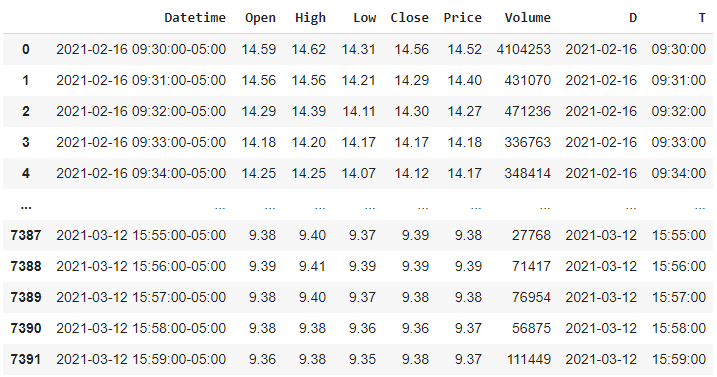

## Get data from Yahoo Finance

In [ ]:
def timeByWeek(weeks=4):
    # create list of 4 pairs start/end date
    # yahoo only provide 4 weeks back date on 1 minute data
    end = datetime.date.today()- datetime.timedelta(1)
    #weeks = 4
    l = []
    for i in range(weeks):
        d = {}
        start = end - datetime.timedelta(7)
        d['start'] = start
        d['end'] = end
        l.append(d)
        end = start
    return l

def YFData(ticker,interval='1m',numWeek=4):
    # get one month of 1 minute data
    l = []
    for i in timeByWeek(numWeek):
        print(i)
        l.append(yf.Ticker(ticker).history(interval=interval,start=i['start'],end=i['end']))
    df = pd.concat(l)
    return df



In [ ]:
# test code
#data = YFMonthMinuteData('BNGO')
#df = formatData(data)

## Get data from Alpha Vantage

In [ ]:
AVkey = 'T8BGSSZLI8NC37WC'

def AV_intraday(symbol, interval='1min', period='year1month1'):
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={symbol}&interval={interval}&slice={period}&adjusted=false&apikey={key}'
    query = url.format(symbol = symbol,interval = interval, period=period, key=AVkey)
    df = pd.read_csv(query)
    df.rename(columns={'time':'Datetime','open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume'}, inplace=True)
    return df

def AV_fundamental(symbol,Print=True):
    url = 'https://www.alphavantage.co/query?function=OVERVIEW&symbol={symbol}&apikey={key}'
    u = url.format(symbol=symbol, key=AVkey)
    data = req.get(u).json()
    if Print:
        print(json.dumps(data,indent=4, sort_keys=True))
    return data



In [ ]:
# test code
#data = AV_intraday('BNGO',period='year1month1')
#formatData(data)

## Class

In [ ]:
class stock():
    def __init__(self, ticker, datasource = 'YF'):
        if datasource == 'YF':
            self.data = formatData(YFData(ticker=ticker,numWeek=4,interval='1m'))
        elif datasource[0] == 'AV':
            # example: BNGO1 = stock('BNGO',['AV','year1month1'])
            data = formatData(AV_intraday(ticker,period=datasource[1]))
            data = data.loc[(data['T']>=datetime.time(9,30)) & (data['T']<=datetime.time(16,0))]
            data.reset_index(drop=True,inplace=True)
            self.data = data

        # MACD -------------------------------------
        self.MACDi = {}
        self.MACDs = {}
        self.MACDt = {}
        for i in [2,5,10,15,20,30,60]:
            self.editMACD(i)
        self.MACDr = reportStrategy(self.MACDt) 

        # VWAP -------------------------------------
        self.VWAPi = VWAP(self.data,'Price')
        self.VWAPs = {}
        self.VWAPt = {}
        for i in [2,5,10,15,20,30,60]:
            self.editVWAP(n=i)
        self.VWAPr = reportStrategy(self.VWAPt)

    # MACD functions -------------------------------------
    def editMACD(self,n):
        self.MACDi[n] = MACD(self.data,'Price',n)
        self.MACDs[n] = MACDstrategy(self.data,'Price',n)
        self.MACDt[n] = Testing(self.data,tradePosition(self.MACDs[n]))

    def plotMACD(self):
        plotTestMACD(self.data)

    # VWAP functions -------------------------------------
    def editVWAP(self,n):
        self.VWAPs[n] = VWAPstrategy(self.VWAPi,n=n)
        self.VWAPt[n] = Testing(self.data,tradePosition(self.VWAPs[n])) 
        

   def reportMACD(self):
        d = {}
        for i in self.MACDt.items():
            d[i[0]]= i[1].groupby('test').growth.sum()
        r = pd.DataFrame(d)
        sum = r.sum()
        r = r.T
        r['tol'] = sum
        r['tolex'] = r.tol - r.even
        self.MACDr = r

## Indicator

### Shared functions

#### Strategic function

##### moving

In [ ]:
def moving(s):
    df = round(pd.DataFrame(s),3)
    df.columns = ['val']
    df['diff'] = df['val'].diff()
   
    df['up'] = np.nan
    df.loc[df['diff'] > 0, 'up'] = 1
    df['updiff'] = df['up'].diff()
   
    df['down'] = np.nan
    df.loc[df['diff'] < 0, 'down'] = -1
    df['downdiff'] = df['down'].diff()

    return df

def moveUp(s):
    df = moving(s)
    i = df.iloc[0].name
    a = df.loc[(df['down'] == -1) & (df['downdiff'].isnull())].iloc[0].name
    return [i,a]

def moveDown(s):
    df = moving(s)
    i = df.iloc[0].name
    a = df.loc[(df['up'] == 1) & (df['updiff'].isnull())].iloc[0].name
    return [i,a ]

def move(s):
    up = moveUp(s)
    down = moveDown(s)
    if up[1] > down[1]:
        return up
    elif up[1] < down[1]:
        return down

##### baseSignalStrategy

In [ ]:
def baseSignalStrategy(data):
    # input dataframe of 2 columns
    # 1st column is base, 2nd column is signal
    # output the classic base/signal buy/sell strategy
    df = data.copy()
    df.columns = ['base','sign']
    df['buy'] = np.nan
    df['sell'] = np.nan
    df.loc[df.sign > df.base,'buy'] = 1
    df.loc[df.sign < df.base,'sell'] = -1
    df['buydiff'] = df['buy'].diff()
    df['selldiff'] = df['sell'].diff()

    buy = df.loc[(df['buy']==1) & (df['buydiff'].isnull())]
    sell = df.loc[(df['sell']==-1) & (df['selldiff'].isnull())]

    df['position'] = np.nan

    for buy_index, i in buy.iterrows():
        try:
            next_sell_index = sell.loc[buy_index:].iloc[0].name
            buydf = df.loc[buy_index:next_sell_index]
            exit_index = moveUp(buydf.sign)[1]
            df.loc[buy_index:exit_index,'position'] = 1
        except:
            pass

    for sell_index,i in sell.iterrows():
        try:
            # using lower level MACD to mark exit point
            next_buy_index = buy.loc[sell_index:].iloc[0].name
            selldf = df.loc[sell_index:next_buy_index]
            exit_index = moveDown(selldf.sign)[1]
            df.loc[sell_index:exit_index,'position'] = -1
        except:
            pass
    return df[['position']]


##### tradePosition

In [ ]:
def tradePosition(data):
    df = data.sort_index()
    df['next'] = df['position'].shift(-1)
    df['diff'] = df['position'].diff()
    df['shift'] = df['diff'].shift(-1)

    buy = df.loc[(df['position']==1) & (df['next']==1) & (df['diff']!=0) & (df['shift']==0)]
    buyexit = df.loc[(df['position']==1)& (df['next']!=1) & (df['diff']==0) & (df['shift']!=0)]

    sell = df.loc[(df['position']==-1) & (df['next']==-1) & (df['diff']!=0) & (df['shift']==0)]
    sellexit = df.loc[(df['position']==-1)& (df['next']!=-1) & (df['diff']==0) & (df['shift']!=0)]

    buydf = pd.DataFrame([buy.index,buyexit.index]).T
    buydf.columns=['entry','exit']
    buydf['position'] = 'long'

    selldf = pd.DataFrame([sell.index,sellexit.index]).T
    selldf.columns=['entry','exit']
    selldf['position'] = 'short'

    df1 = pd.concat([buydf,selldf])
    df1.sort_values('entry',inplace=True,ignore_index=True)
    return df1

input for tradingPosition  
  
    
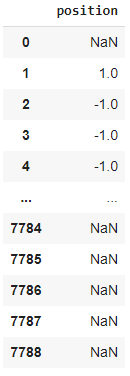

output for tradingPosition  
  
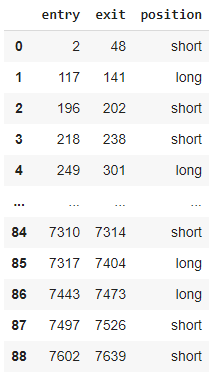

##### Testing

In [ ]:
def Testing(stockdata,testdata):
# feed in the stock data and the suggestion trad data
# the suggestion trade data should have the correct format with buy index, sell index and position label
# function will follow suggestion trade and return win/lose profit/lost report
    
    l=[]
    df= stockdata.sort_values('Datetime',ignore_index=True)
    for e,i in testdata.iterrows():
        d={}
        order = sorted([i.entry,i.exit])

        d['entryID'] = order[0]
        d['exitID'] = order[1]

        entry = df.loc[order[0]]
        exit = df.loc[order[1]]
        d['date'] = entry['D']  

        d['entryP'] = entry.Price
        d['exitP'] = exit.Price
        d['entryT'] = entry['T']
        d['exitT'] = exit['T']
        d['position'] = i.position

        growth = round(d['exitP']/d['entryP'],2)
        if growth > 1:
            if d['position'] == 'long':
                d['growth'] = growth - 1
                d['test'] = 'win'
            if d['position'] == 'short':
                d['growth'] = -(growth - 1)
                d['test'] = 'lose'
        elif growth < 1:
            if d['position'] == 'long':
                d['growth'] = - (1 - growth)
                d['test'] = 'lose'
            if d['position'] == 'short':
                d['growth'] = 1-growth
                d['test'] = 'win'
        else:
            d['growth'] = -0.005
            d['test'] = 'even'

        l.append(d)
    return pd.DataFrame(l)



input for Testing  

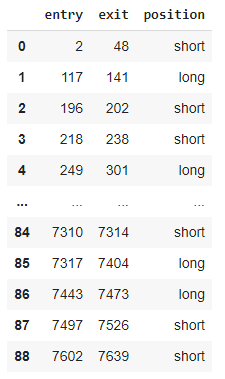

ouput for Testing  
  
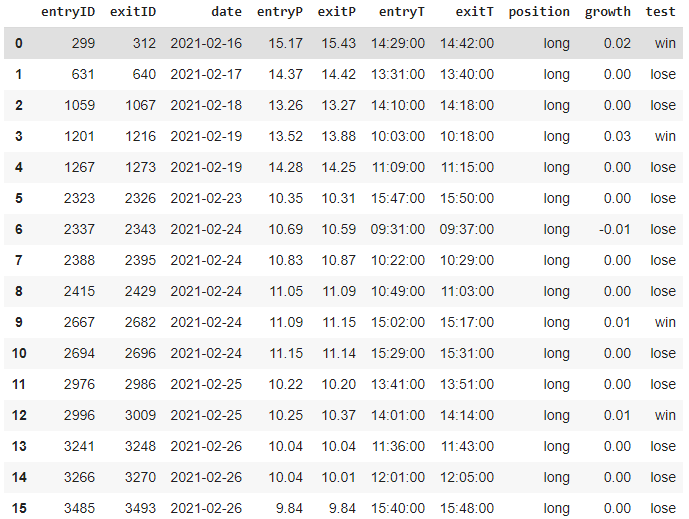

##### reportStrategy

In [ ]:
def reportStrategy(di):
        d = {}
        for i in di.items():
            d[i[0]]= i[1].groupby('test').growth.sum()
        r = pd.DataFrame(d)
        r.fillna(0,inplace=True)
        sum = round(r.sum(),3)
        r = r.T
        r['tol'] = sum
        r['tolex'] = r.tol - r.even
        return r

##### testLog

In [ ]:
def testLog(stock,testResult):
    # feed in stock and test result
    # used for plotting testing result
    print('Logging test result')
    df =  pd.DataFrame(stock.index, columns=['test'])
    df['test'] = 0
    df['time'] = 0
    for e,i in testResult.iterrows():
        if i['growth'] == 0:
            df.loc[i['entryID']:i['exitID'],'test'] = -0.002
            df.loc[i['entryID']:i['exitID'],'time'] = i.exitID - i.entryID
            df.loc[i['entryID']:i['exitID'],'position'] = i.position
            

        else:
            df.loc[i['entryID']:i['exitID'],'test'] = i['growth']
            df.loc[i['entryID']:i['exitID'],'time'] = i.exitID - i.entryID
            df.loc[i['entryID']:i['exitID'],'position'] = i.position
    

    return df

output of testLog should follow the format below, it use index as locator to plot trade in the plot

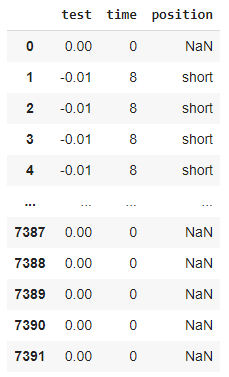

#### Plotting function

In [ ]:
def figLayout(stock):
    # configure the x axis tick, label and daily separate line in the layout
    group = stock.groupby('D')
    shape = []
    date = []
    lid = []
    for i in group.groups.keys():
        item = group.get_group(i).iloc[0]
        id = item.name
        dt = item['Datetime'].strftime('%m-%d')
        d = dict(type='line', xref='x',yref='paper',x0=id, y0=0, x1=id, y1=1, line = dict(color='grey', width=1,dash='dot'))
        shape.append(d)
        date.append(dt)
        lid.append(id)

    return {'shape':shape,'date':date,'tick':lid}

In [ ]:
def addTraceTrade(fig,df,r,c,name,color='steelblue', lg= False):
    # feed in testLog
    # use for plotting the test result on chart
    fig.add_trace(go.Scatter(x=df.index, y = df.test,
                             line_shape='hv',
                             fill='tozeroy',
                             hovertext=df['time'],
                             name=name,
                             legendgroup = name, 
                             showlegend = lg, 
                             line=dict(width=0.1, color=color))
    , row=r, col=c)


### MACD

#### MACD indicator

In [ ]:
# MACD indicator
def MACD(data,p='Price',n=2):
    df= data.copy()
    df.sort_values('Datetime',ignore_index=True)
    exp1 = df[p].ewm(span=12*n, adjust=False).mean()
    exp2 = df[p].ewm(span=26*n, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9*n, adjust=False).mean()
    histogram = macd - signal
    df['macd'] = macd
    df['signal'] = signal
    df['macdhist'] = histogram
    return df

In [ ]:
#test code
#MACD(df,'Price')

#### MACD strategy

##### Version 1

In [ ]:
def MACDstrategy(data,p,n= 5):
    stock = data.copy()
    df = MACD(stock,'Price',n=n)[['signal','macd']]
    df['preposition'] = baseSignalStrategy(df).position
    df['position'] = np.nan
    df.loc[(df.signal > 0) & (df.preposition == 1),'position'] = 1
    df.loc[(df.signal < 0) & (df.preposition == -1),'position'] = -1
    return df[['position']]


##### Version 2

def MACDstrategy(data,p,n= 5):
    stock = data.copy()
    df = pd.DataFrame(stock.index)
    # getting two levels of MACD
    df[['signal2','hist2']] = MACD(stock,'Price',n=n)[['signal','macdhist']]
    df[['signal1','hist1']] = MACD(stock,'Price',n=round(n/2))[['signal','macdhist']]

    # marking buy zone - when both hist are positive
    df['buy'] = np.nan
    df.loc[(df['hist1'] > 0) & (df['hist2'] > 0), 'buy'] = 1
    df['buydiff'] = df['buy'].diff()

    #marking sell zone - when both hist are negative
    df['sell'] = np.nan
    df.loc[(df['hist1'] < 0) & (df['hist2'] < 0), 'sell'] = -1
    df['selldiff'] = df['sell'].diff()

    # marking the begining of long and short call
    buy = df.loc[(df['buy']==1) & (df['buydiff'].isnull())]
    sell = df.loc[(df['sell']==-1) & (df['selldiff'].isnull())]

    # fishing for the end of each long and short call
    #l = []
    df['position'] = np.nan
    for buy_index, i in buy.iterrows():
        try:
            # using lower level MACD to mark exit point
            next_sell_index = sell.loc[buy_index:].iloc[0].name
            buydf = df.loc[buy_index:next_sell_index]
            exit_index = moveUp(buydf.hist2)[1]
            df.loc[buy_index:exit_index,'position'] = 1
            #l.append({'entry':buy_index,'exit':exit_index,'position':'long'})
        except:
            pass
    
    for sell_index,i in sell.iterrows():
        try:
            # using lower level MACD to mark exit point
            next_buy_index = buy.loc[sell_index:].iloc[0].name
            selldf = df.loc[sell_index:next_buy_index]
            exit_index = moveDown(selldf.hist2)[1]
            df.loc[sell_index:exit_index,'position'] = -1

            #l.append({'entry':sell_index,'exit':exit_index,'position':'short'})
        except:
            pass
    return df[['position']]

output of strategy  
1 for long and -1 for short  
  
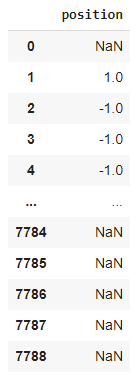

#### MACD reporting

In [ ]:
def MACDtesting(stock):
    # returning a dictionry of 4 different n interval for MACD
    # each key-value pair hold a data frame as the Testing function out put
    # useful for mass ploting and access performance
    df = stock.copy()
    df.reset_index(drop=True, inplace=True)
    testResult = {}
    testResult['n02'] = Testing(df,tradePosition(MACDstrategy(df,'Price',n=2)))
    testResult['n05'] = Testing(df,tradePosition(MACDstrategy(df,'Price',n=5)))
    testResult['n10'] = Testing(df,tradePosition(MACDstrategy(df,'Price',n=10)))
    testResult['n20'] = Testing(df,tradePosition(MACDstrategy(df,'Price',n=20)))
    for i in testResult.keys():
        testResult[i]['interval'] = i
    return testResult

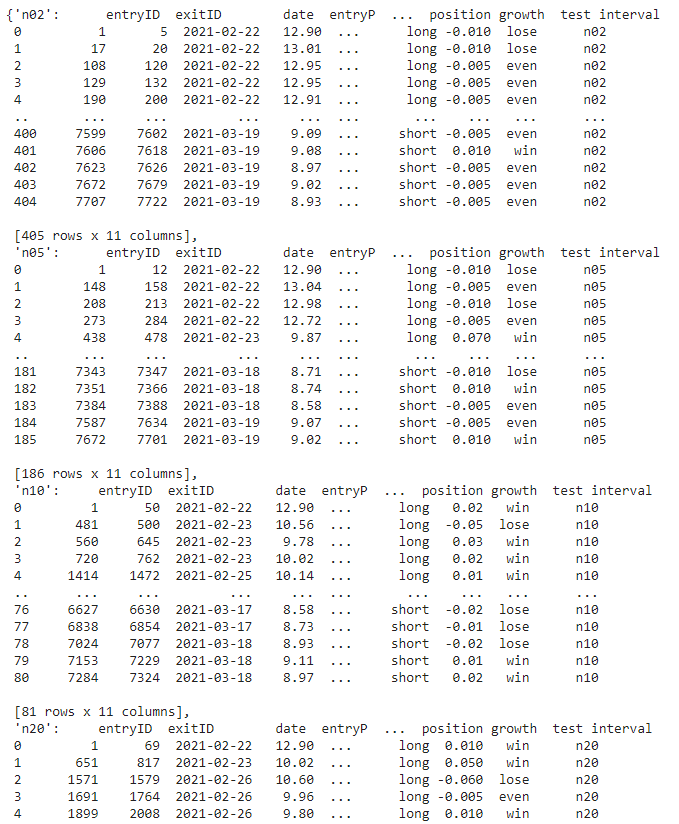

In [ ]:
def MACDtestReport(stock,even=True):
    # return a dataframe breaking down MACD performance
    # this function use MACD strategy applying on daily base and concat into month
    # break down by day - then by interval n, 4 interval in total
    # with growth/benchmark comparision
    # the 'even' argument will filter out 'even' trade, only take into account win and lose
    group = stock.groupby('D')
    l=[]
    for i in group.groups.keys():
        day = group.get_group(i)
        test = pd.concat(MACDtesting(day).values())
        if even == True:
            df = test.loc[test.test != 'even'].groupby(['interval']).sum()
        else:
            df = test.groupby(['interval']).sum()
        df['bmark'] = dailyGrowth(day.Price)
        df['D'] = i
        l.append(df)
    df1 = pd.concat(l)
    df1.reset_index(inplace=True)
    return df1

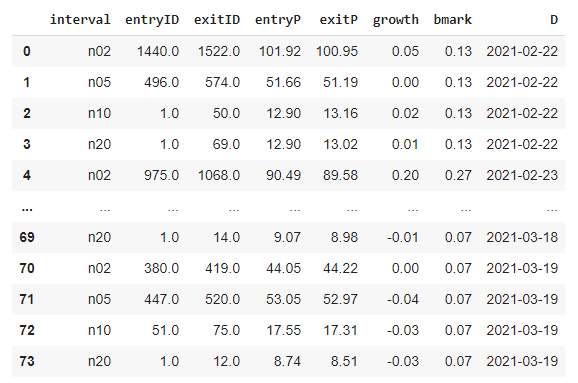

In [ ]:
def testMACDonList(stocklist,even=True):
    # return a dataframe break down MACD performance on a stock list
    # break down by stock name - then by day - then by interval n (4 in total)
    # with growth//benchmark comparision
    # the 'even' argument will filter out 'even' trade, only take into account win and lose

    stockListDict = {}
    for i in stocklist:
        try:
            stock = formatData(YFData(ticker=i, numWeek=4, interval='1m'))
            stockListDict[i] = MACDtestReport(stock,even=even)
        except:
            pass
    # calculate the peformance
    l = []
    for stock in stockListDict.keys():
        temp =stockListDict[stock]
        for n in ['n02','n05','n10','n20']:
            try:
                a = temp.loc[temp.interval == n][['growth','bmark']].sum().to_dict()
                a['stock'] = stock
                a['n'] = n
                l.append(a)
            except:
                pass
    return pd.DataFrame(l)

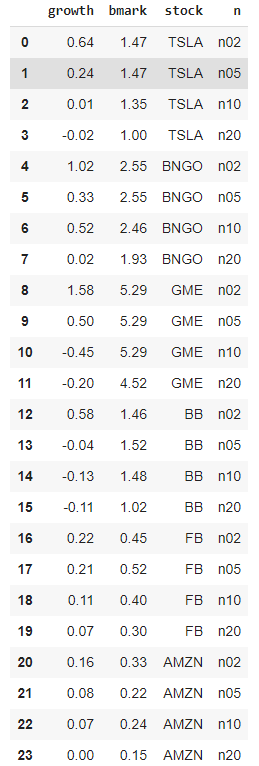

#### MACD test plot

In [ ]:
def addTraceMACD(fig,df,r,c):
    # adding MACD indicator to the plot
    fig.add_trace(go.Scatter(x=df.loc[df.macdhist>0].index, y = df.loc[df.macdhist>0].macdhist, fill= 'tozeroy',line=dict(width=0.1, color='green'),name='hist',legendgroup = 'hist',showlegend=False),row=r, col=c)
    fig.add_trace(go.Scatter(x=df.loc[df.macdhist<0].index, y = df.loc[df.macdhist<0].macdhist, fill= 'tozeroy',line=dict(width=0.1, color='red'),name='hist',legendgroup = 'hist',showlegend=False),row=r, col=c)
    fig.add_trace(go.Scatter(x=df.index, y=df.signal, name='signal',line_color='orange',legendgroup = 'signal',showlegend=False),row=r, col=c)
    fig.add_trace(go.Scatter(x=df.index, y=df.macd, name='macd',line_color='steelblue', legendgroup = 'macd',showlegend=False),row=r, col=c)

In [ ]:
def plotTestMACD(stock):
    #stock.reset_index(drop=True, inplace=True)
    df = stock.copy()
    df.reset_index(drop=True, inplace=True)

    layout = figLayout(df)

    fig = make_subplots(rows=8,cols=1,shared_xaxes=True,vertical_spacing=0.02)

    fig.add_trace(go.Scatter(x=df.index,y=df.Price, hovertext=df['T'],showlegend=False, name='price'),row=1,col=1)
    fig.add_trace(go.Scatter(x=df.index,y=df.loc[df['T']!=datetime.time(9,30)].Volume, hovertext=df['T'],showlegend=False, name='volume',line_shape='hv',fill='tozeroy', line=dict(width=0.1, color='red')),row=2,col=1)
    addTraceMACD(fig,MACD(df,'Price',n=2),r=3,c=1)
    addTraceMACD(fig,MACD(df,'Price',n=5),r=4,c=1)
    addTraceMACD(fig,MACD(df,'Price',n=10),r=5,c=1)
    addTraceMACD(fig,MACD(df,'Price',n=20),r=6,c=1)


    testResult = MACDtesting(df)



    #testResult['n2'] = n2.groupby('position')
    #testResult['n5'] = n5.groupby('position')
    #testResult['n10'] = n10.groupby('position')
    #testResult['n20'] = n20.groupby('position')

    position = {'long':{}, 'short':{}}
    for p in position.keys():
        for t in testResult.keys():
            try:
                position[p][t] = testLog(df,testResult[t].groupby('position').get_group(p))
            except:
                pass

    color = ['green','red','steelblue','orange']
    c = 0
    for i in position['long'].keys():
        addTraceTrade(fig,position['long'][i],r=7,c=1,name=i,lg=False,color=color[c])
        c+=1
    c =0 
    for i in position['short'].keys():
        addTraceTrade(fig,position['short'][i],r=8,c=1,name=i,lg=True, color=color[c])
        c+= 1


    fig.update_layout(height = 900,
                        hovermode = 'x',
                        shapes = layout['shape'],
                        xaxis8 = dict(tickmode='array', tickvals=layout['tick'], ticktext=layout['date']))
    fig.show()

    for i in testResult.keys():
        testResult[i]['interval'] = i



    def MACDreport(ds):
        
        fig = make_subplots(rows=3 , cols = 4, shared_yaxes=True, shared_xaxes=True, vertical_spacing=0.02, horizontal_spacing=0.02)
        for e in range(len(ds)):
            try:
                ptn = ds[e].groupby(['position','test','growth']).count()
                for i in [['long',1],['short',2]]:
                    for c in [['win','green'],['lose','red'],['even','grey']]:
                        try:
                            fig.add_trace(go.Bar(x=ptn.loc[(i[0],c[0])].index, y = ptn.loc[(i[0],c[0])].exitP, marker_color=c[1], name=c[0], legendgroup=c[0],showlegend=False),row=i[1],col=e+1)
                        except:
                            pass
            except:
                pass
            try:
                tn = ds[e].groupby(['test','growth']).count()
                for c in [['win','green'],['lose','red'],['even','grey']]:
                    if e == 0:
                        try:
                            fig.add_trace(go.Bar(x=tn.loc[c[0]].index, y = tn.loc[c[0]].exitP, marker_color=c[1], name=c[0], legendgroup=c[0],showlegend=True),row=3,col=e+1)
                        except:
                            pass
                    else:
                        try:
                            fig.add_trace(go.Bar(x=tn.loc[c[0]].index, y = tn.loc[c[0]].exitP, marker_color=c[1], name=c[0], legendgroup=c[0],showlegend=False),row=3,col=e+1)
                        except:
                            pass 
            except:
                pass

        df = pd.concat(ds)
        fig1 = make_subplots(rows=3 , cols = 1,  vertical_spacing=0.02, shared_xaxes=True)
        n=1
        for e in ['long','short','combine']:
            if e != 'combine':
                df1 = df.loc[df['position']==e]
            else:
                df1 = df.copy()
            for i in [['even','grey'],['lose','red'],['win','green']]:
                try:
                    temp = abs(df1.loc[df1['test'] == i[0]].groupby('interval').sum().growth)
                    fig1.add_trace(go.Bar(x=temp.index, y=temp.values,name=i[0],legendgroup=i[0],showlegend=False if e != 'combine' else True,marker_color=i[1]),row=n,col=1)
                except:
                    pass

            n+=1
        fig.update_layout(height = 500, hovermode = 'x')
        fig1.update_layout(height = 500, hovermode = 'x')
        fig.show()
        fig1.show()

    MACDreport(list(testResult.values()))
    


MACD plotting use all the functions related to MACD strategy to plot out the indicator and the test result (4x for different scale period)  
**When running on a slice of data, that slice need to be reset index - stock input data need to have ordered index**

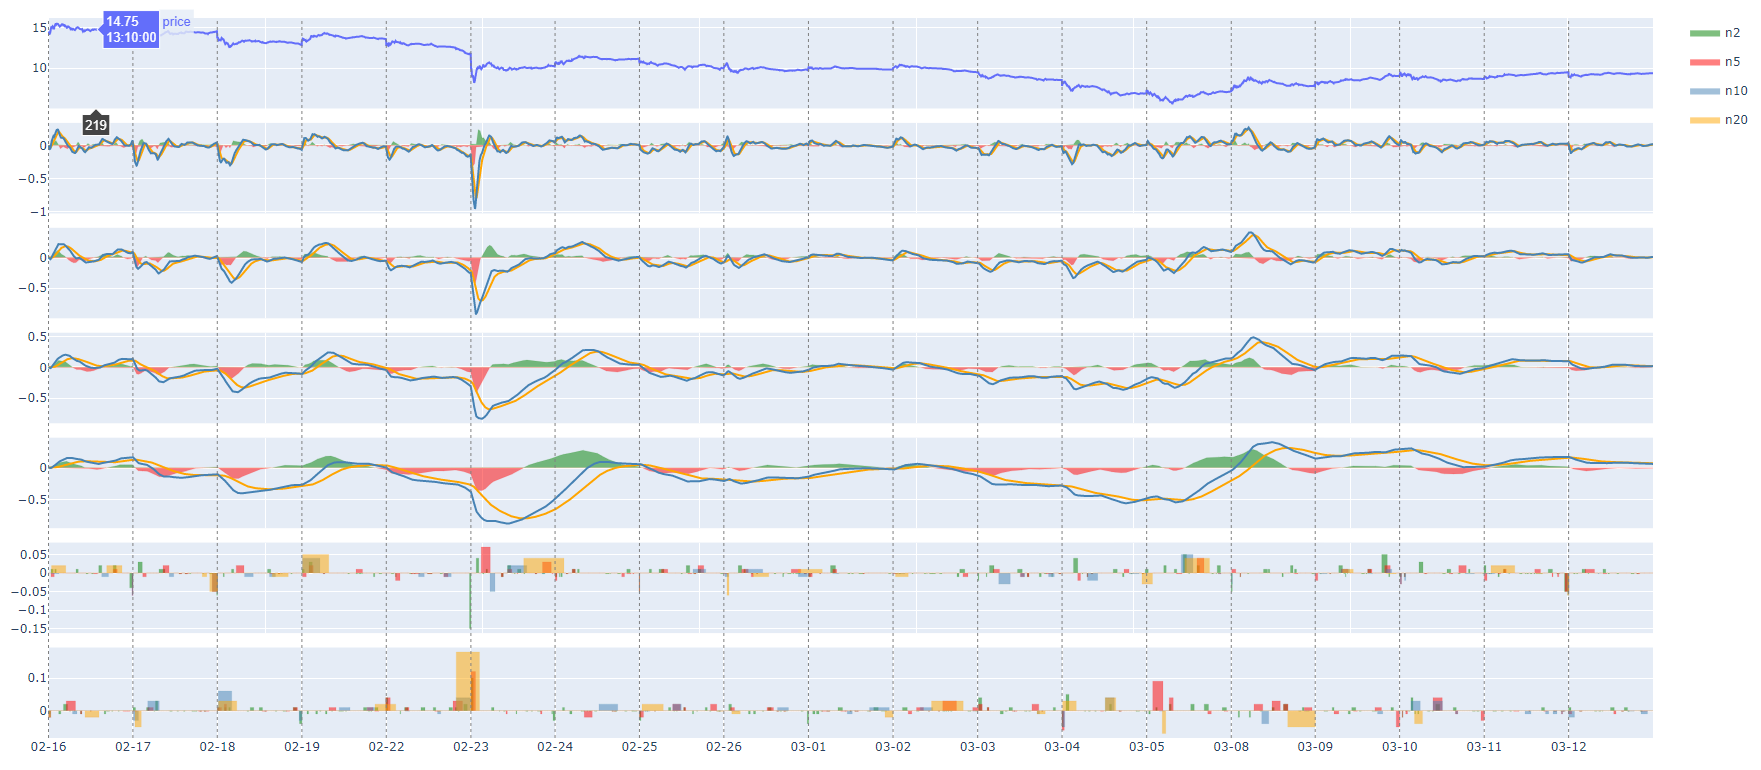

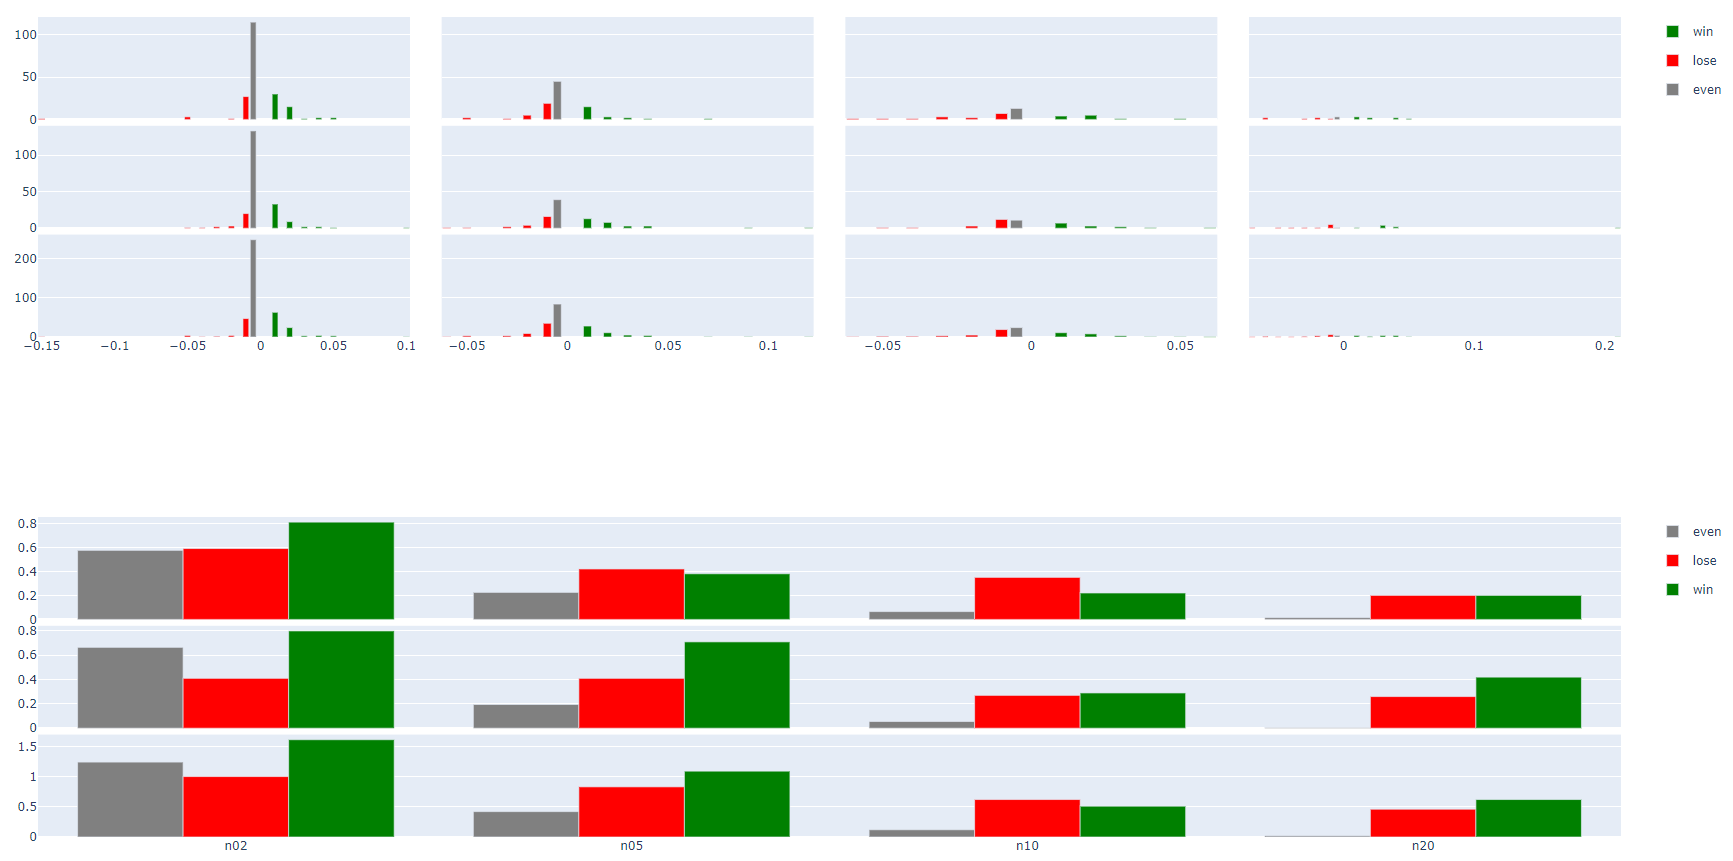

In [ ]:
def plotMACDlistTest(testResult):
    # input test result from testMACDonList
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True)
    for i in [['n02',1],['n05',2],['n10',3],['n20',4]]:
        temp = testResult.loc[testResult.n == i[0]]
        fig.add_trace(go.Bar(x=temp.stock, y = temp.growth, name='growth',legendgroup='growth',marker_color='orange', showlegend = (True if i[1]== 1 else False)),row=i[1],col=1)
        fig.add_trace(go.Bar(x=temp.stock, y = temp.bmark, name='bmark', legendgroup='bmark',marker_color='grey',showlegend = (True if i[1]== 1 else False)),row=i[1],col=1)
    fig.update_layout(height = 500, hovermode = 'x')
    fig.show()

### VWAP

#### VWAP indicator

In [ ]:
def VWAPcal(data, p):
#VWAP calculation
    df= data.copy()
    df.sort_values('Datetime',ignore_index=True,inplace=True)
    VWAP = (df[p]*df.Volume).cumsum() / df.Volume.cumsum()
    df['vwap'] = VWAP
    return df

def VWAP(data,p='Price'):
# VWAP indicator, run on a daily basic
# as the curve smoothen further down the time line
    df = data.copy()
    df.sort_values('Datetime',inplace=True)
    df = df.groupby('D').apply(lambda x: VWAPcal(x,p)).reset_index(drop=True)
    return df

#### VWAP strategy

In [ ]:
def VWAPstrategy(data,p='Price',n=2):
    #input stock data with vwap data
    df = data.copy()
    df.sort_values('Datetime',ignore_index=True,inplace=True)
    df['avg'] = df.Price.ewm(span=n, adjust=False).mean()
    return baseSignalStrategy(df[['vwap','avg']])


In [ ]:
#test code
#VWAP(df,'Price')

### Ichimoku Kinko Hyo

In [ ]:
def ICMK(data):
    df = data.copy()
    df.sort_values('Datetime',ignore_index=True,inplace=True)
    conversion = (df.High.rolling(9).max() + df.Low.rolling(9).min())/2
    base = (df.High.rolling(26).max() + df.Low.rolling(26).min())/2
    leadA = (conversion + base)/2
    leadB = (df.High.rolling(52).max() + df.Low.rolling(52).min())/2
    lag = df.Close.shift(-26)
    df['icmk_conversion'] = conversion
    df['icmk_base'] = base
    df['icmk_leadA'] = leadA
    df['icmk_leadB'] = leadB
    df['icmk_lag'] = lag
    return df


In [ ]:
#test code
#ICMK(df,'Price')